In [224]:
key = #insert key

In [216]:
import weave
import json
from openai import OpenAI
import fitz
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import re
from prompts3 import *
import pandas as pd
import wandb
import random

In [218]:
def HumanRubric(rubric_file):
    """Create data frame of human scoring rubric given csv file of scored rubric. 
       Index represents question number

    Arguments:
        file - filepath name of human scored csv file
    Returns:
        human_rubric_df - df of human scored rubric  
    """
    # Create cleaned DF of questions 
    human_rubric_df = pd.read_csv(rubric_file)
    human_rubric_df = human_rubric_df.iloc[10:, 3:]
    human_rubric_df = human_rubric_df.reset_index()
    human_rubric_df = human_rubric_df.drop('index', axis=1)
    human_rubric_df.columns = human_rubric_df.iloc[0]
    human_rubric_df = human_rubric_df[1:]

    return human_rubric_df

# Construct Training and Validation Sets, Output as JSONL

In [ ]:
import pandas as pd
import json
import random
from math import ceil

#rubric_files and prompts should be in list format
def process_rubric_files(rubric_files, prompts, train_ratio=0.8):
    # Function to create combined text list
    def create_combined_list(rubric, prompts, no_test_set):
        combined_list = []
        for i, row in rubric.iterrows():
            if i in no_test_set:
                continue
            if i < len(prompts):
                combined_text = 'Section From GSP: ' + row['Relevant Text from GSP'] + ' Question: ' + prompts[i]
                combined_list.append(combined_text)
            else:
                break
        return combined_list

    # Function to process human answers
    def process_human_answers(human_answers, no_test_set):
        human_answers = human_answers.drop(no_test_set, errors='ignore')
        return ['No' if item == 'Somewhat' else item for item in human_answers]

    # Function to create JSON objects
    def create_json_objects(combined_list, human_answers, system_message):
        json_objects = []
        max_length = min(len(combined_list), len(human_answers))
        for i in range(max_length):
            json_object = {
                "messages": [
                    system_message,
                    {"role": "user", "content": combined_list[i]},
                    {"role": "assistant", "content": human_answers[i]}
                ]
            }
            json_objects.append(json_object)
        return json_objects

    # Define the initial system message
    system_message = {
        "role": "system",
        "content": "You are a skeptical environmental scientist, tasked with answering questions about a section from a Groundwater Sustainability Plan (GSP) document. You are only allowed to give one word answers. Answer the questions objectively, adhering to the provided spectrums."
    }

    # Initialize lists for combined data
    all_combined_list = []
    all_human_answers = []
    no_test = [2, 8, 9, 10, 11, 12, 13, 15, 16, 19, 20, 21, 23, 26, 27, 35, 38, 39, 69]
    no_test_set = set(no_test)

    # Process each rubric and combine the data
    for rubric_file in rubric_files:
        rubric = HumanRubric(rubric_file).dropna(subset=['Relevant Text from GSP'])
        combined_list = create_combined_list(rubric, prompts, no_test_set)
        human_answers = process_human_answers(rubric['Answer'], no_test_set)
        all_combined_list.extend(combined_list)
        all_human_answers.extend(human_answers)

    # Combine combined_list and human_answers into a single DataFrame for easier manipulation
    df = pd.DataFrame({
        'combined_text': all_combined_list,
        'human_answer': all_human_answers
    })

    # Separate "Yes" and "No" answers
    yes_answers = df[df['human_answer'] == 'Yes']
    no_answers = df[df['human_answer'] == 'No']

    # Shuffle both dataframes
    yes_answers = yes_answers.sample(frac=1).reset_index(drop=True)
    no_answers = no_answers.sample(frac=1).reset_index(drop=True)

    # Calculate number of entries for train and validation sets
    total_entries = len(df)
    train_size = ceil(train_ratio * total_entries)
    val_size = total_entries - train_size

    # Select equal number of "Yes" and "No" for the validation set
    val_yes = yes_answers.iloc[:val_size//2]
    val_no = no_answers.iloc[:val_size//2]

    # Combine validation set
    val_set = pd.concat([val_yes, val_no])

    # Remaining "Yes" and "No" for the training set
    train_yes = yes_answers.iloc[val_size//2:]
    train_no = no_answers.iloc[val_size//2:]

    # Combine training set
    train_set = pd.concat([train_yes, train_no])

    # If there are any remaining entries in df that were not selected in yes_answers and no_answers, add them to train_set
    remaining_entries = df[~df.index.isin(train_set.index) & ~df.index.isin(val_set.index)]
    train_set = pd.concat([train_set, remaining_entries])

    # Adjust the size of the training set to ensure it contains the correct number of entries
    train_set = train_set.sample(n=train_size, random_state=42).reset_index(drop=True)

    # Ensure the training and validation sets have the correct number of entries
    #assert len(train_set) == train_size, f"Expected {train_size} entries in the training set, but found {len(train_set)}"
    #assert len(val_set) == val_size, f"Expected {val_size} entries in the validation set, but found {len(val_set)}"

    # Create JSON objects for training and validation data
    train_json_objects = create_json_objects(train_set['combined_text'].tolist(), train_set['human_answer'].tolist(), system_message)
    val_json_objects = create_json_objects(val_set['combined_text'].tolist(), val_set['human_answer'].tolist(), system_message)

    # Serialize and save the training data
    train_json_output = json.dumps(train_json_objects, indent=4)
    with open("gde_train.json", "w") as file:
        file.write(train_json_output)

    # Serialize and save the validation data
    val_json_output = json.dumps(val_json_objects, indent=4)
    with open("gde_val.json", "w") as file:
        file.write(val_json_output)

    # Convert training data to JSONL format
    with open("gde_train.jsonl", 'w') as file:
        for entry in train_json_objects:
            json_string = json.dumps(entry)
            file.write(json_string + '\n')

    # Convert validation data to JSONL format
    with open("gde_val.jsonl", 'w') as file:
        for entry in val_json_objects:
            json_string = json.dumps(entry)
            file.write(json_string + '\n')

    print("Processing complete!")
    print(f"Training set size: {train_size} entries")
    print(f"Validation set size: {val_size} entries")


In [ ]:
# Example usage
rubric_files = [
    'GSP_Drafts/Rubrics/11_Butte_DraftGSP_ScoringRubric - Coding.csv',
    'GSP_Drafts/Rubrics/55_SantaMargarita_DraftGSP_ScoringRubric - Coding.csv',
    'GSP_Drafts/Rubrics/15_Fillmore_DraftGSP_ScoringRubric - Coding.csv'
]

process_rubric_files(rubric_files, prompts)

# Create Fine-Tuning Model in Notebook

In [ ]:
def upload_json_l(json_l):
    client = OpenAI(key)

    client.files.create(
      file=open(json_l, "rb"),
      purpose="fine-tune"
    )

In [240]:
def fine_tune_model(api_key, training_file_id, validation_file_id, epochs, gpt_model, lr):
    client = OpenAI(api_key=key)

    # Create fine-tune job
    client.fine_tuning.jobs.create(
        training_file=training_file_id,
        validation_file=validation_file_id,
        model=gpt_model,  
        hyperparameters={
        "n_epochs":epochs,
        "learning_rate_multiplier": lr   
        }
    )

In [242]:
fine_tune_model(key, 'file-4k66WxuYgkGfPNznottsAs5g', 'file-KDPqdSxKb60VW4IYzCdVSPJA', 7, 'gpt-3.5-turbo-0125', lr=.5)

# Testing

In [225]:
def extract_text_from_pdf(pdf_path):
    """
    Extracts text from a PDF file, preserving page breaks.

    :param pdf_path: The path to the PDF file.
    :return: A string containing the extracted text with page breaks.
    """
    document = fitz.open(pdf_path)
    text = []

    for page_num in range(len(document)):
        page = document.load_page(page_num)
        text.append(page.get_text("text"))
    
    # Join the text of each page with form feed characters to indicate page breaks
    return '\f'.join(text)

def split_into_pages(text):
    """
    Splits the text into pages.
    
    :param text: The complete text extracted from the PDF.
    :return: A list of pages.
    """
    pages = text.split('\f')
    return pages

def get_embedding(text):
    """
    Fetches the embedding for a given text using OpenAI's API.
    
    :param text: The text to get the embedding for.
    :return: A vector representation of the text.
    """
    client = OpenAI(api_key=key)
    text = text.replace("\n", " ")
    return client.embeddings.create(input = [text], model="text-embedding-3-large").data[0].embedding

def get_embeddings(full_text):
    """
    Splits the full text into pages and computes embeddings for each page.

    :param full_text: The complete text extracted from the source.
    :return: A list of text pages and their corresponding embeddings.
    """
    pages = split_into_pages(full_text)
    embeddings = []
    for page in pages:
        page_embedding = get_embedding(page)
        embeddings.append(page_embedding)
    return pages, embeddings

def find_most_relevant_pages(pages, embeddings, question, top_n=10):
    """
    Finds the most relevant text pages to a given question using pre-computed embeddings and cosine similarity.

    :param pages: A list of text pages corresponding to the embeddings.
    :param embeddings: A list of embeddings for each page of text.
    :param question: The question for which to find the relevant pages.
    :param top_n: The number of top relevant pages to return.
    :return: The top N most relevant pages of the text.
    """
    question_embedding = get_embedding(question) 
    scores = []

    # Iterate over the embeddings and pages together
    for page, page_embedding in zip(pages, embeddings):
        score = cosine_similarity([question_embedding], [page_embedding])[0][0]
        scores.append((score, page))
        
    # Sort the pages by score in descending order
    scores.sort(reverse=True, key=lambda x: x[0])
    
    # Get the top N pages
    most_relevant_pages = [page for score, page in scores[:top_n]]
    
    # Combine the most relevant pages into a continuous string
    continuous_text = '\n'.join(most_relevant_pages)
    
    return continuous_text

In [227]:
def compare_lists(list1, list2):
    differences = []
    if len(list1) != len(list2):
        return None, "Lists are of different lengths and cannot be compared index by index."
    for i in range(len(list1)):
        if list1[i] != list2[i]:
            differences.append(i)
    return differences

In [ ]:
pdf = extract_text_from_pdf('GSP_Drafts/1_BigValley.pdf')
bv_pages, bv_embeddings = get_embeddings(pdf)

In [ ]:
pdf = extract_text_from_pdf('GSP_Drafts/14_ECC.pdf')
ecc_pages, ecc_embeddings = get_embeddings(pdf)

In [ ]:
pdf = extract_text_from_pdf('GSP_Drafts/15_Fillmore.pdf')
fillmore_pages, fillmore_embeddings = get_embeddings(pdf)

In [ ]:
pdf = extract_text_from_pdf('GSP_Drafts/30_Sonoma.pdf')
sonoma_pages, sonoma_embeddings = get_embeddings(pdf)

In [ ]:
pdf = extract_text_from_pdf('GSP_Drafts/46_Modesto.pdf')
modesto_pages, modesto_embeddings = get_embeddings(pdf)

In [228]:
pdf = extract_text_from_pdf('GSP_Drafts/50_SLO.pdf')
slo_pages, slo_embeddings = get_embeddings(pdf)

In [229]:
def ChatGDE(pages, embeddings, prompts, rubric_file, no_test, gde_answer_function):
    answers = []
    
    # Generate answers based on pages and embeddings
    for i in range(1, 71):
        if i not in no_test:
            section = find_most_relevant_pages(pages, embeddings, prompts[i-1])
            section_and_question = section + prompts[i-1]
            answers.append(gde_answer_function(section_and_question))
    
    # Load rubric and process chat answers
    rubric = HumanRubric(rubric_file)
    chat_answers = rubric['Answer']
    chat_answers = chat_answers.drop(no_test, errors='ignore')
    chat_answers = ['No' if item == 'Somewhat' else item for item in chat_answers]
    chat_answers = ['NotApplicable' if item == 'Not Applicable' else item for item in chat_answers]
    
    # Compare lists and print differences
    differences = compare_lists(answers, chat_answers)
    if differences:
        print("Differences at indices:", differences)
    else:
        print("No differences. Lists are identical.")

    # Print count of differences
    print(f"Number of differences: {len(differences)}")

# Tests That I Tried Out

In [230]:
no_test = [8, 9, 10, 11, 12, 13, 15, 16, 19, 20, 21, 23, 26, 27, 38, 39, 69]

In [ ]:
def gde_answer(section_and_question: str) -> dict:
    client = OpenAI(api_key=key)

    response = client.chat.completions.create(
    model="ft:gpt-3.5-turbo-0125:personal:balanced-lr-1:9JPxtozx",
    messages=[
        {
            "role": "system",
            "content": "You are a skeptical environmental scientist, tasked with answering questions\
            about a section from a Groundwater Sustainability Plan (GSP) document. You are only allowed to give one\
            word answers. Answer the questions objectively, adhering to the provided spectrums."
        },
        {
            "role": "user",
            "content": section_and_question
        }
        ],
        temperature=0.7,
        #response_format={ "type": "json_object" }
    )
    extracted = response.choices[0].message.content
    #return json.loads(extracted)
    return extracted

#weave.init('intro-example') # 🐝

In [231]:
ChatGDE(slo_pages, slo_embeddings, prompts, 
        'GSP_Drafts/Rubrics/50_SanLuisObispoValley_DraftGSP_ScoringRubric - Coding.csv', no_test, gde_answer)

Differences at indices: [0, 1, 3, 9, 13, 14, 21, 24, 25, 26, 38, 40, 46, 47, 48, 49, 52]
Number of differences: 17


#### Fillmore Test

In [39]:
fillmore_answers = []
for i in range(1,71):
    if i not in no_test:
        section = find_most_relevant_pages(fillmore_pages, fillmore_embeddings, prompts[i-1])
        section_and_question = section + prompts[i-1]
        fillmore_answers.append(gde_answer(section_and_question))

In [ ]:
rubric = HumanRubric('GSP_Drafts/Rubrics/15_Fillmore_DraftGSP_ScoringRubric - Coding.csv')
fillmore_chat_answers = rubric['Answer']
fillmore_chat_answers = fillmore_chat_answers.drop(no_test, errors='ignore')
fillmore_chat_answers = ['No' if item == 'Somewhat' else item for item in fillmore_chat_answers]
fillmore_chat_answers = ['NotApplicable' if item == 'Not Applicable' else item for item in fillmore_chat_answers]

In [40]:
differences = compare_lists(fillmore_answers, fillmore_chat_answers)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [1, 2, 3, 4, 9, 10, 11, 12, 13, 14, 20, 23, 25, 38, 39, 40, 46, 47, 52]


#### Modesto Test

In [42]:
modesto_answers = []
for i in range(1,71):
    if i not in no_test:
        section = find_most_relevant_pages(modesto_pages, modesto_embeddings, prompts[i-1])
        section_and_question = section + prompts[i-1]
        modesto_answers.append(gde_answer(section_and_question))

In [43]:
rubric = HumanRubric('GSP_Drafts/Rubrics/46_Modesto_DraftGSP_ScoringRubric - Coding.csv')

In [44]:
modesto_chat_answers = rubric['Answer']
modesto_chat_answers = modesto_chat_answers.drop(no_test, errors='ignore')
modesto_chat_answers = ['No' if item == 'Somewhat' else item for item in modesto_chat_answers]
modesto_chat_answers = ['NotApplicable' if item == 'Not Applicable' else item for item in modesto_chat_answers]

In [45]:
differences = compare_lists(modesto_answers, modesto_chat_answers)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [0, 1, 3, 4, 6, 7, 8, 9, 10, 13, 15, 17, 18, 19, 21, 22, 24, 26, 28, 34, 40, 41, 42, 43, 47, 48, 52]


#### SLO Test

In [48]:
slo_answers = []
for i in range(1,71):
    if i not in no_test:
        section = find_most_relevant_pages(slo_pages, slo_embeddings, prompts[i-1])
        section_and_question = section + prompts[i-1]
        slo_answers.append(gde_answer(section_and_question))

In [196]:
rubric = HumanRubric('GSP_Drafts/Rubrics/50_SanLuisObispoValley_DraftGSP_ScoringRubric - Coding.csv')
slo_chat_answers = rubric['Answer']
slo_chat_answers = slo_chat_answers.drop(no_test, errors='ignore')
slo_chat_answers = ['No' if item == 'Somewhat' else item for item in slo_chat_answers]
slo_chat_answers = ['NotApplicable' if item == 'Not Applicable' else item for item in slo_chat_answers]

In [50]:
differences = compare_lists(slo_answers, slo_chat_answers)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [0, 1, 3, 9, 13, 14, 21, 24, 25, 26, 38, 40, 46, 47, 48, 52]


#### Big Valley Test

In [52]:
bv_chat_answers = []

In [53]:
for i in range(1,71):
    if i not in no_test:
        section = find_most_relevant_pages(bv_pages, bv_embeddings, prompts[i-1])
        section_and_question = section + prompts[i-1]
        bv_chat_answers.append(gde_answer(section_and_question))

In [184]:
rubric = HumanRubric('GSP_Drafts/Rubrics/1_BigValley_DraftGSP_ScoringRubric - Coding.csv')
bv_answers = rubric['Answer']
no_test = [2, 8, 9, 10, 11, 12, 13, 15, 16, 19, 20, 21, 23, 26, 27, 35, 38, 39, 69]
bv_answers = bv_answers.drop(no_test, errors='ignore')
bv_answers = ['No' if item == 'Somewhat' else item for item in bv_answers]
bv_answers = ['NotApplicable' if item == 'Not Applicable' else item for item in bv_answers]

In [57]:
differences = compare_lists(bv_answers, bv_chat_answers)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [1, 14, 21, 25, 38, 40, 42, 45, 47, 52]


#### Sonoma Valley Test

In [58]:
sonoma_chat_answers = []

In [59]:
for i in range(1,71):
    if i not in no_test:
        section = find_most_relevant_pages(sonoma_pages, sonoma_embeddings, prompts[i-1])
        section_and_question = section + prompts[i-1]
        sonoma_chat_answers.append(gde_answer(section_and_question))

In [191]:
rubric = HumanRubric('GSP_Drafts/Rubrics/30_SonomaValley_DraftGSP_ScoringRubric - Coding.csv')
sonoma_answers = rubric['Answer']
sonoma_answers = sonoma_answers.drop(no_test, errors='ignore')
sonoma_answers = ['No' if item == 'Somewhat' else item for item in sonoma_answers]
sonoma_answers = ['NotApplicable' if item == 'Not Applicable' else item for item in sonoma_answers]

In [62]:
differences = compare_lists(sonoma_answers, sonoma_chat_answers)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [0, 1, 2, 4, 5, 10, 11, 12, 14, 19, 24, 25, 28, 32, 35, 45, 49, 51, 52]


#### ECC Test

In [63]:
ecc_chat_answers = []

In [64]:
for i in range(1,71):
    if i not in no_test:
        section = find_most_relevant_pages(ecc_pages, ecc_embeddings, prompts[i-1])
        section_and_question = section + prompts[i-1]
        ecc_chat_answers.append(gde_answer(section_and_question))

In [197]:
rubric = HumanRubric('GSP_Drafts/Rubrics/14_EastContraCosta_DraftGSP_ScoringRubric - Coding.csv')
ecc_answers = rubric['Answer']
ecc_answers = ecc_answers.drop(no_test, errors='ignore')
ecc_answers = ['No' if item == 'Somewhat' else item for item in ecc_answers]
ecc_answers = ['NotApplicable' if item == 'Not Applicable' else item for item in ecc_answers]

In [68]:
differences = compare_lists(ecc_answers, ecc_chat_answers)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [1, 4, 7, 10, 11, 12, 16, 19, 26, 28, 32, 39, 42, 45, 46, 48, 49, 52]


### .5 Learning Rate

In [120]:
def gde_answer(section_and_question: str) -> dict:
    client = OpenAI(api_key=key)

    response = client.chat.completions.create(
    model="ft:gpt-3.5-turbo-0125:personal:balanced-lr-half:9Lw1LNkY",
    messages=[
        {
            "role": "system",
            "content": "You are a skeptical environmental scientist, tasked with answering questions\
            about a section from a Groundwater Sustainability Plan (GSP) document. You are only allowed to give one\
            word answers. Answer the questions objectively, adhering to the provided spectrums."
        },
        {
            "role": "user",
            "content": section_and_question
        }
        ],
        temperature=0.7,
    )
    extracted = response.choices[0].message.content
    return extracted

#weave.init('intro-example') # 🐝

In [121]:
bv_chat_answers_2_b = []

In [122]:
for i in range(1,71):
    if i not in no_test:
        section = find_most_relevant_pages(bv_pages, bv_embeddings, prompts[i-1])
        section_and_question = section + prompts[i-1]
        bv_chat_answers_2_b.append(gde_answer(section_and_question))

In [73]:
differences = compare_lists(bv_chat_answers, bv_chat_answers_2)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [1, 14, 25, 38, 40, 42, 45, 47, 52]


In [123]:
differences = compare_lists(bv_chat_answers, bv_chat_answers_2_b)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [1, 14, 25, 38, 40, 45, 47, 52]


In [124]:
sonoma_chat_answers_2_b = []

In [125]:
for i in range(1,71):
    if i not in no_test:
        section = find_most_relevant_pages(sonoma_pages, sonoma_embeddings, prompts[i-1])
        section_and_question = section + prompts[i-1]
        sonoma_chat_answers_2_b.append(gde_answer(section_and_question))

In [76]:
differences = compare_lists(sonoma_answers, sonoma_chat_answers_2)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [1, 2, 4, 5, 10, 12, 14, 19, 24, 25, 28, 32, 35, 40, 44, 45, 48, 49, 51]


In [126]:
differences = compare_lists(sonoma_answers, sonoma_chat_answers_2_b)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [1, 2, 4, 5, 10, 12, 14, 19, 24, 25, 28, 32, 35, 40, 44, 45, 48, 49, 51, 52]


In [127]:
ecc_chat_answers_2_b = []

In [128]:
for i in range(1,71):
    if i not in no_test:
        section = find_most_relevant_pages(ecc_pages, ecc_embeddings, prompts[i-1])
        section_and_question = section + prompts[i-1]
        ecc_chat_answers_2_b.append(gde_answer(section_and_question))

In [79]:
differences = compare_lists(ecc_answers, ecc_chat_answers_2)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [1, 4, 6, 7, 10, 11, 12, 16, 19, 26, 28, 32, 36, 38, 45, 46, 48, 49]


In [129]:
differences = compare_lists(ecc_answers, ecc_chat_answers_2_b)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [1, 4, 7, 10, 11, 12, 16, 19, 20, 26, 28, 32, 36, 38, 45, 46, 48, 49]


In [130]:
fillmore_chat_answers_2_b = []

In [131]:
for i in range(1,71):
    if i not in no_test:
        section = find_most_relevant_pages(fillmore_pages, fillmore_embeddings, prompts[i-1])
        section_and_question = section + prompts[i-1]
        fillmore_chat_answers_2_b.append(gde_answer(section_and_question))

In [102]:
differences = compare_lists(fillmore_chat_answers, fillmore_chat_answers_2)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [1, 3, 4, 9, 10, 12, 13, 14, 23, 25, 36, 38, 39, 40, 44, 46, 50]


In [132]:
differences = compare_lists(fillmore_chat_answers, fillmore_chat_answers_2_b)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [1, 3, 4, 9, 10, 11, 12, 13, 14, 23, 25, 36, 38, 39, 44, 46, 50]


In [133]:
slo_chat_answers_2_b = []

In [134]:
for i in range(1,71):
    if i not in no_test:
        section = find_most_relevant_pages(slo_pages, slo_embeddings, prompts[i-1])
        section_and_question = section + prompts[i-1]
        slo_chat_answers_2_b.append(gde_answer(section_and_question))

In [106]:
differences = compare_lists(slo_chat_answers, slo_chat_answers_2)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [0, 1, 3, 9, 13, 14, 24, 25, 26, 36, 38, 40, 44, 46, 47]


In [135]:
differences = compare_lists(slo_chat_answers, slo_chat_answers_2_b)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [0, 1, 3, 9, 13, 14, 24, 25, 26, 36, 38, 40, 44, 46, 47]


# Regular GPT-4 for comparison

In [108]:
def gde_answer(section_and_question: str) -> dict:
    client = OpenAI(api_key=key)

    response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {
            "role": "system",
            "content": "You are a skeptical environmental scientist, tasked with answering questions\
            about a section from a Groundwater Sustainability Plan (GSP) document. You are only allowed to give one\
            word answers. Answer the questions objectively, adhering to the provided spectrums."
        },
        {
            "role": "user",
            "content": section_and_question
        }
        ],
        temperature=0.7,
        #response_format={ "type": "json_object" }
    )
    extracted = response.choices[0].message.content
    #return json.loads(extracted)
    return extracted

#weave.init('intro-example') # 🐝

In [83]:
bv_chat_answers_3 = []

In [84]:
for i in range(1,71):
    if i not in no_test:
        section = find_most_relevant_pages(bv_pages, bv_embeddings, prompts[i-1])
        section_and_question = section + prompts[i-1]
        bv_chat_answers_3.append(gde_answer(section_and_question))

In [85]:
differences = compare_lists(bv_chat_answers, bv_chat_answers_3)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [0, 2, 4, 5, 6, 9, 10, 11, 12, 14, 16, 19, 22, 26, 30, 33, 34, 35, 36, 41, 42, 43, 46, 47, 48, 50, 51]


In [86]:
sonoma_chat_answers_3 = []

In [87]:
for i in range(1,71):
    if i not in no_test:
        section = find_most_relevant_pages(sonoma_pages, sonoma_embeddings, prompts[i-1])
        section_and_question = section + prompts[i-1]
        sonoma_chat_answers_3.append(gde_answer(section_and_question))

In [88]:
differences = compare_lists(sonoma_answers, sonoma_chat_answers_3)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [0, 1, 3, 4, 6, 9, 10, 11, 14, 15, 19, 21, 22, 23, 24, 25, 26, 28, 30, 32, 33, 35, 43, 44, 45, 46, 48]


In [89]:
ecc_chat_answers_3 = []

In [90]:
for i in range(1,71):
    if i not in no_test:
        section = find_most_relevant_pages(ecc_pages, ecc_embeddings, prompts[i-1])
        section_and_question = section + prompts[i-1]
        ecc_chat_answers_3.append(gde_answer(section_and_question))

In [91]:
differences = compare_lists(ecc_answers, ecc_chat_answers_3)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 16, 18, 19, 22, 23, 25, 28, 30, 32, 33, 36, 39, 40, 41, 43, 45, 46, 48, 50, 52]


In [111]:
fillmore_chat_answers_3 = []

In [112]:
for i in range(1,71):
    if i not in no_test:
        section = find_most_relevant_pages(slo_pages, slo_embeddings, prompts[i-1])
        section_and_question = section + prompts[i-1]
        fillmore_chat_answers_3.append(gde_answer(section_and_question))

In [113]:
differences = compare_lists(fillmore_chat_answers, fillmore_chat_answers_3)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [1, 2, 4, 5, 10, 11, 12, 14, 16, 17, 20, 21, 22, 24, 25, 26, 30, 33, 37, 38, 40, 43, 45, 46, 47, 48, 49, 50, 51]


In [107]:
slo_chat_answers_3 = []

In [109]:
for i in range(1,71):
    if i not in no_test:
        section = find_most_relevant_pages(slo_pages, slo_embeddings, prompts[i-1])
        section_and_question = section + prompts[i-1]
        slo_chat_answers_3.append(gde_answer(section_and_question))

In [115]:
differences = compare_lists(slo_chat_answers, slo_chat_answers_3)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [0, 2, 3, 4, 5, 8, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25, 30, 33, 36, 37, 39, 40, 43, 46, 47, 48, 49, 50, 51]


# More Epochs

In [146]:
def gde_answer(section_and_question: str) -> dict:
    client = OpenAI(api_key=key)

    response = client.chat.completions.create(
    model="ft:gpt-3.5-turbo-0125:personal:lr-half-moreepochs:9MfPnpO0",
    messages=[
        {
            "role": "system",
            "content": "You are a skeptical environmental scientist, tasked with answering questions\
            about a section from a Groundwater Sustainability Plan (GSP) document. You are only allowed to give one\
            word answers. Answer the questions objectively, adhering to the provided spectrums."
        },
        {
            "role": "user",
            "content": section_and_question
        }
        ],
        temperature=0.7,
        #response_format={ "type": "json_object" }
    )
    extracted = response.choices[0].message.content
    #return json.loads(extracted)
    return extracted

#weave.init('intro-example') # 🐝

In [147]:
no_test = [8, 9, 10, 11, 12, 13, 15, 16, 19, 20, 21, 23, 26, 27, 38, 39, 69]
pdf = clean_pdf_text(extract_text_from_pdf('GSP_Drafts/1_BigValley.pdf'))
sections, embeddings = get_embeddings(pdf, split_size=50)
bv_chat_answers_3 = []

In [152]:
for i in range(1,71):
    if i not in no_test:
        section = find_most_relevant_section(sections, embeddings, prompts[i-1])
        section_and_question = section + prompts[i-1]
        bv_chat_answers_3.append(gde_answer(section_and_question))

In [153]:
differences = compare_lists(bv_answers, bv_chat_answers_3)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [1, 14, 15, 17, 18, 35, 38, 39, 40, 45, 47, 52]


In [154]:
pdf = clean_pdf_text(extract_text_from_pdf('GSP_Drafts/30_Sonoma.pdf'))
sections, embeddings = get_embeddings(pdf, split_size=50)
sonoma_chat_answers_3 = []

In [155]:
for i in range(1,71):
    if i not in no_test:
        section = find_most_relevant_section(sections, embeddings, prompts[i-1])
        section_and_question = section + prompts[i-1]
        sonoma_chat_answers_3.append(gde_answer(section_and_question))

In [156]:
differences = compare_lists(sonoma_answers, sonoma_chat_answers_3)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [1, 2, 4, 5, 6, 10, 12, 13, 14, 19, 20, 24, 25, 28, 32, 35, 37, 38, 40, 44, 45, 48, 49, 50, 51, 52]


In [157]:
pdf = clean_pdf_text(extract_text_from_pdf('GSP_Drafts/14_ECC.pdf'))
sections, embeddings = get_embeddings(pdf, split_size=40)
ecc_chat_answers_3 = []

In [158]:
for i in range(1,71):
    if i not in no_test:
        section = find_most_relevant_section(sections, embeddings, prompts[i-1])
        section_and_question = section + prompts[i-1]
        ecc_chat_answers_3.append(gde_answer(section_and_question))

In [159]:
differences = compare_lists(ecc_answers, ecc_chat_answers_3)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [1, 4, 7, 10, 11, 12, 15, 16, 17, 19, 20, 26, 28, 32, 36, 47, 48, 49, 52]


# OG Slight Imbalance

In [160]:
def gde_answer(section_and_question: str) -> dict:
    client = OpenAI(api_key=key)

    response = client.chat.completions.create(
    model="ft:gpt-3.5-turbo-0125:personal::9HbS53fX",
    messages=[
        {
            "role": "system",
            "content": "You are a skeptical environmental scientist, tasked with answering questions\
            about a section from a Groundwater Sustainability Plan (GSP) document. You are only allowed to give one\
            word answers. Answer the questions objectively, adhering to the provided spectrums."
        },
        {
            "role": "user",
            "content": section_and_question
        }
        ],
        temperature=0.7,
        #response_format={ "type": "json_object" }
    )
    extracted = response.choices[0].message.content
    #return json.loads(extracted)
    return extracted

#weave.init('intro-example') # 🐝

In [161]:
no_test = [8, 9, 10, 11, 12, 13, 15, 16, 19, 20, 21, 23, 26, 27, 38, 39, 69]
pdf = clean_pdf_text(extract_text_from_pdf('GSP_Drafts/1_BigValley.pdf'))
sections, embeddings = get_embeddings(pdf, split_size=50)
bv_chat_answers_4 = []

In [162]:
for i in range(1,71):
    if i not in no_test:
        section = find_most_relevant_section(sections, embeddings, prompts[i-1])
        section_and_question = section + prompts[i-1]
        bv_chat_answers_4.append(gde_answer(section_and_question))

In [163]:
differences = compare_lists(bv_answers, bv_chat_answers_4)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [1, 6, 8, 14, 15, 17, 18, 20, 38, 39, 40, 47, 52]


In [164]:
pdf = clean_pdf_text(extract_text_from_pdf('GSP_Drafts/30_Sonoma.pdf'))
sections, embeddings = get_embeddings(pdf, split_size=50)
sonoma_chat_answers_4 = []

In [165]:
for i in range(1,71):
    if i not in no_test:
        section = find_most_relevant_section(sections, embeddings, prompts[i-1])
        section_and_question = section + prompts[i-1]
        sonoma_chat_answers_4.append(gde_answer(section_and_question))

In [166]:
differences = compare_lists(sonoma_answers, sonoma_chat_answers_4)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [1, 2, 4, 5, 6, 8, 10, 12, 13, 14, 19, 20, 24, 25, 28, 32, 35, 36, 37, 40, 45, 48, 49, 50, 51, 52]


# GPT-4 Human Rationale

In [122]:
def gde_answer(section_and_question: str) -> dict:
    client = OpenAI(api_key=key)

    response = client.chat.completions.create(
    model="gpt-4-turbo-2024-04-09",
    messages=[
        {
            "role": "system",
            "content": "You are a skeptical environmental scientist, tasked with answering questions\
            about a section from a Groundwater Sustainability Plan (GSP) document. You are only allowed to give one\
            word answers. Answer the questions objectively, adhering to the provided spectrums."
        },
        {
            "role": "user",
            "content": section_and_question
        }
        ],
        temperature=0.7,
        #response_format={ "type": "json_object" }
    )
    extracted = response.choices[0].message.content
    #return json.loads(extracted)
    return extracted

#weave.init('intro-example') # 🐝

In [138]:
rubric = HumanRubric('GSP_Drafts/Rubrics/1_BigValley_DraftGSP_ScoringRubric - Coding.csv')

In [139]:
rubric = rubric.dropna(subset=['Relevant Text from GSP'])

In [140]:
combined_list = []
no_test = [8, 9, 10, 11, 12, 13, 15, 16, 19, 20, 21, 23, 26, 27, 38, 39, 69]

# Convert no_test to a set for faster lookup
no_test_set = set(no_test)

# Iterate over the trimmed DataFrame
for i, row in rubric.iterrows():
    # Skip rows that are in the no_test set
    if i in no_test_set:
        continue

    # Ensure there's a matching prompt in the list
    if i < len(prompts):
        combined_text = 'Section From GSP:' + ' ' + row['Relevant Text from GSP'] \
                        + ' ' + 'Question:' + ' ' + prompts[i-1]
        combined_list.append(combined_text)
    else:
        break  # In case the DataFrame is longer than the list, this prevents out-of-index errors

In [141]:
human_rationale_answers = []

In [142]:
human_answers = rubric['Answer']
human_answers = human_answers.drop(no_test, errors='ignore')
human_answers = ['No' if item == 'Somewhat' else item for item in human_answers]

In [143]:
len(combined_list)

32

In [144]:
for i in range(len(combined_list)):
    human_rationale_answers.append(gde_answer(combined_list[i]))

In [145]:
differences = compare_lists(human_rationale_answers, human_answers)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [0, 1, 4, 6, 7, 11, 21, 25, 26, 28, 29, 30, 31]


# Expanded Fine-Tuning Model

In [175]:
def gde_answer(section_and_question: str) -> dict:
    client = OpenAI(api_key=key)

    response = client.chat.completions.create(
    model="ft:gpt-3.5-turbo-0125:personal::9XGPsPzW",
    messages=[
        {
            "role": "system",
            "content": "You are a skeptical environmental scientist, tasked with answering questions\
            about a section from a Groundwater Sustainability Plan (GSP) document. You are only allowed to give one\
            word answers. Answer the questions objectively, adhering to the provided spectrums."
        },
        {
            "role": "user",
            "content": section_and_question
        }
        ],
        temperature=0.7,
        #response_format={ "type": "json_object" }
    )
    extracted = response.choices[0].message.content
    #return json.loads(extracted)
    return extracted

#weave.init('intro-example') # 🐝

In [176]:
bv_chat_expanded = []

In [177]:
for i in range(1,71):
    if i not in no_test:
        section = find_most_relevant_pages(bv_pages, bv_embeddings, prompts[i-1])
        section_and_question = section + prompts[i-1]
        bv_chat_expanded.append(gde_answer(section_and_question))

In [185]:
differences = compare_lists(bv_chat_expanded, bv_answers)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [3, 5, 7, 8, 10, 13, 15, 20, 23, 38, 39, 45, 48]


In [186]:
sonoma_chat_expanded = []

In [187]:
for i in range(1,71):
    if i not in no_test:
        section = find_most_relevant_pages(sonoma_pages, sonoma_embeddings, prompts[i-1])
        section_and_question = section + prompts[i-1]
        sonoma_chat_expanded.append(gde_answer(section_and_question))

In [192]:
differences = compare_lists(sonoma_chat_expanded, sonoma_answers)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [0, 2, 3, 4, 5, 7, 8, 9, 11, 13, 15, 18, 19, 20, 22, 23, 26, 30, 33, 34, 38, 43, 46, 47, 49]


In [193]:
slo_chat_expanded = []

In [194]:
for i in range(1,71):
    if i not in no_test:
        section = find_most_relevant_pages(slo_pages, slo_embeddings, prompts[i-1])
        section_and_question = section + prompts[i-1]
        slo_chat_expanded.append(gde_answer(section_and_question))

In [199]:
differences = compare_lists(slo_chat_expanded, slo_chat_answers)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [0, 2, 5, 7, 12, 13, 15, 20, 22, 23, 24, 34, 38, 41, 44, 45, 47]


In [200]:
ecc_chat_expanded = []

In [201]:
for i in range(1,71):
    if i not in no_test:
        section = find_most_relevant_pages(ecc_pages, ecc_embeddings, prompts[i-1])
        section_and_question = section + prompts[i-1]
        ecc_chat_expanded.append(gde_answer(section_and_question))

In [203]:
differences = compare_lists(ecc_chat_expanded, ecc_answers)
if differences:
    print("Differences at indices:", differences)
else:
    print("No differences. Lists are identical.")

Differences at indices: [1, 3, 5, 6, 7, 8, 9, 10, 11, 15, 18, 20, 24, 26, 30, 34, 36, 43, 44, 46, 48]


# Visualizations

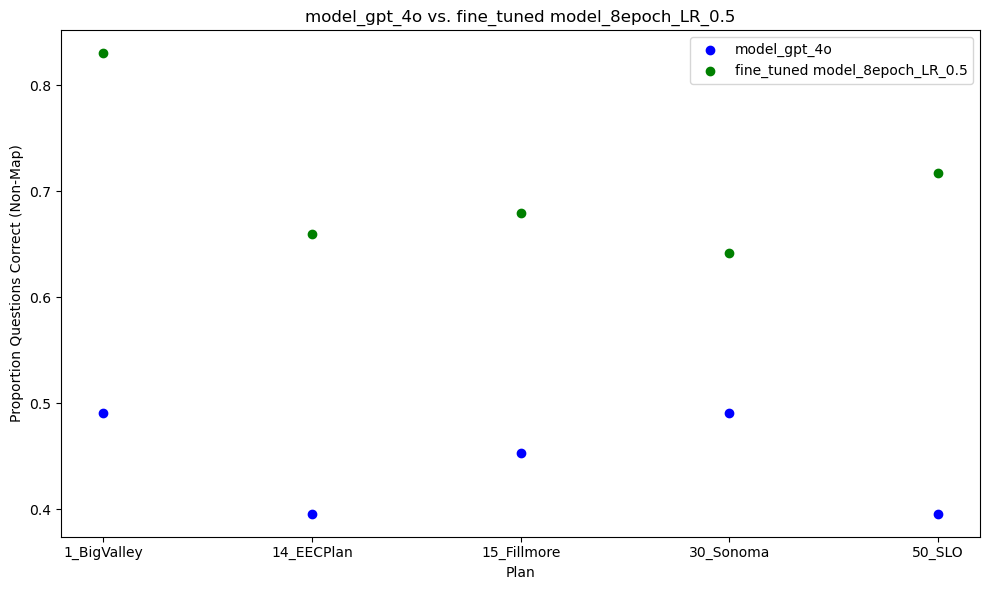

In [118]:
import matplotlib.pyplot as plt

# Data for the scatter plot
x_labels = ['1_BigValley', '14_EECPlan', '15_Fillmore', '30_Sonoma', '50_SLO']
model_gpt_4o = [0.491, 0.396, 0.453, 0.491, 0.396]
ft_model_8epoch_LR_0_5 = [0.830, 0.660, 0.679, 0.642, 0.717]
x = range(len(x_labels))

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, model_gpt_4o, color='blue', label='model_gpt_4o')
plt.scatter(x, ft_model_8epoch_LR_0_5, color='green', label='fine_tuned model_8epoch_LR_0.5')

# Adding titles and labels
plt.title('model_gpt_4o vs. fine_tuned model_8epoch_LR_0.5')
plt.xlabel('Plan')
plt.ylabel('Proportion Questions Correct (Non-Map)')
plt.xticks(x, x_labels)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

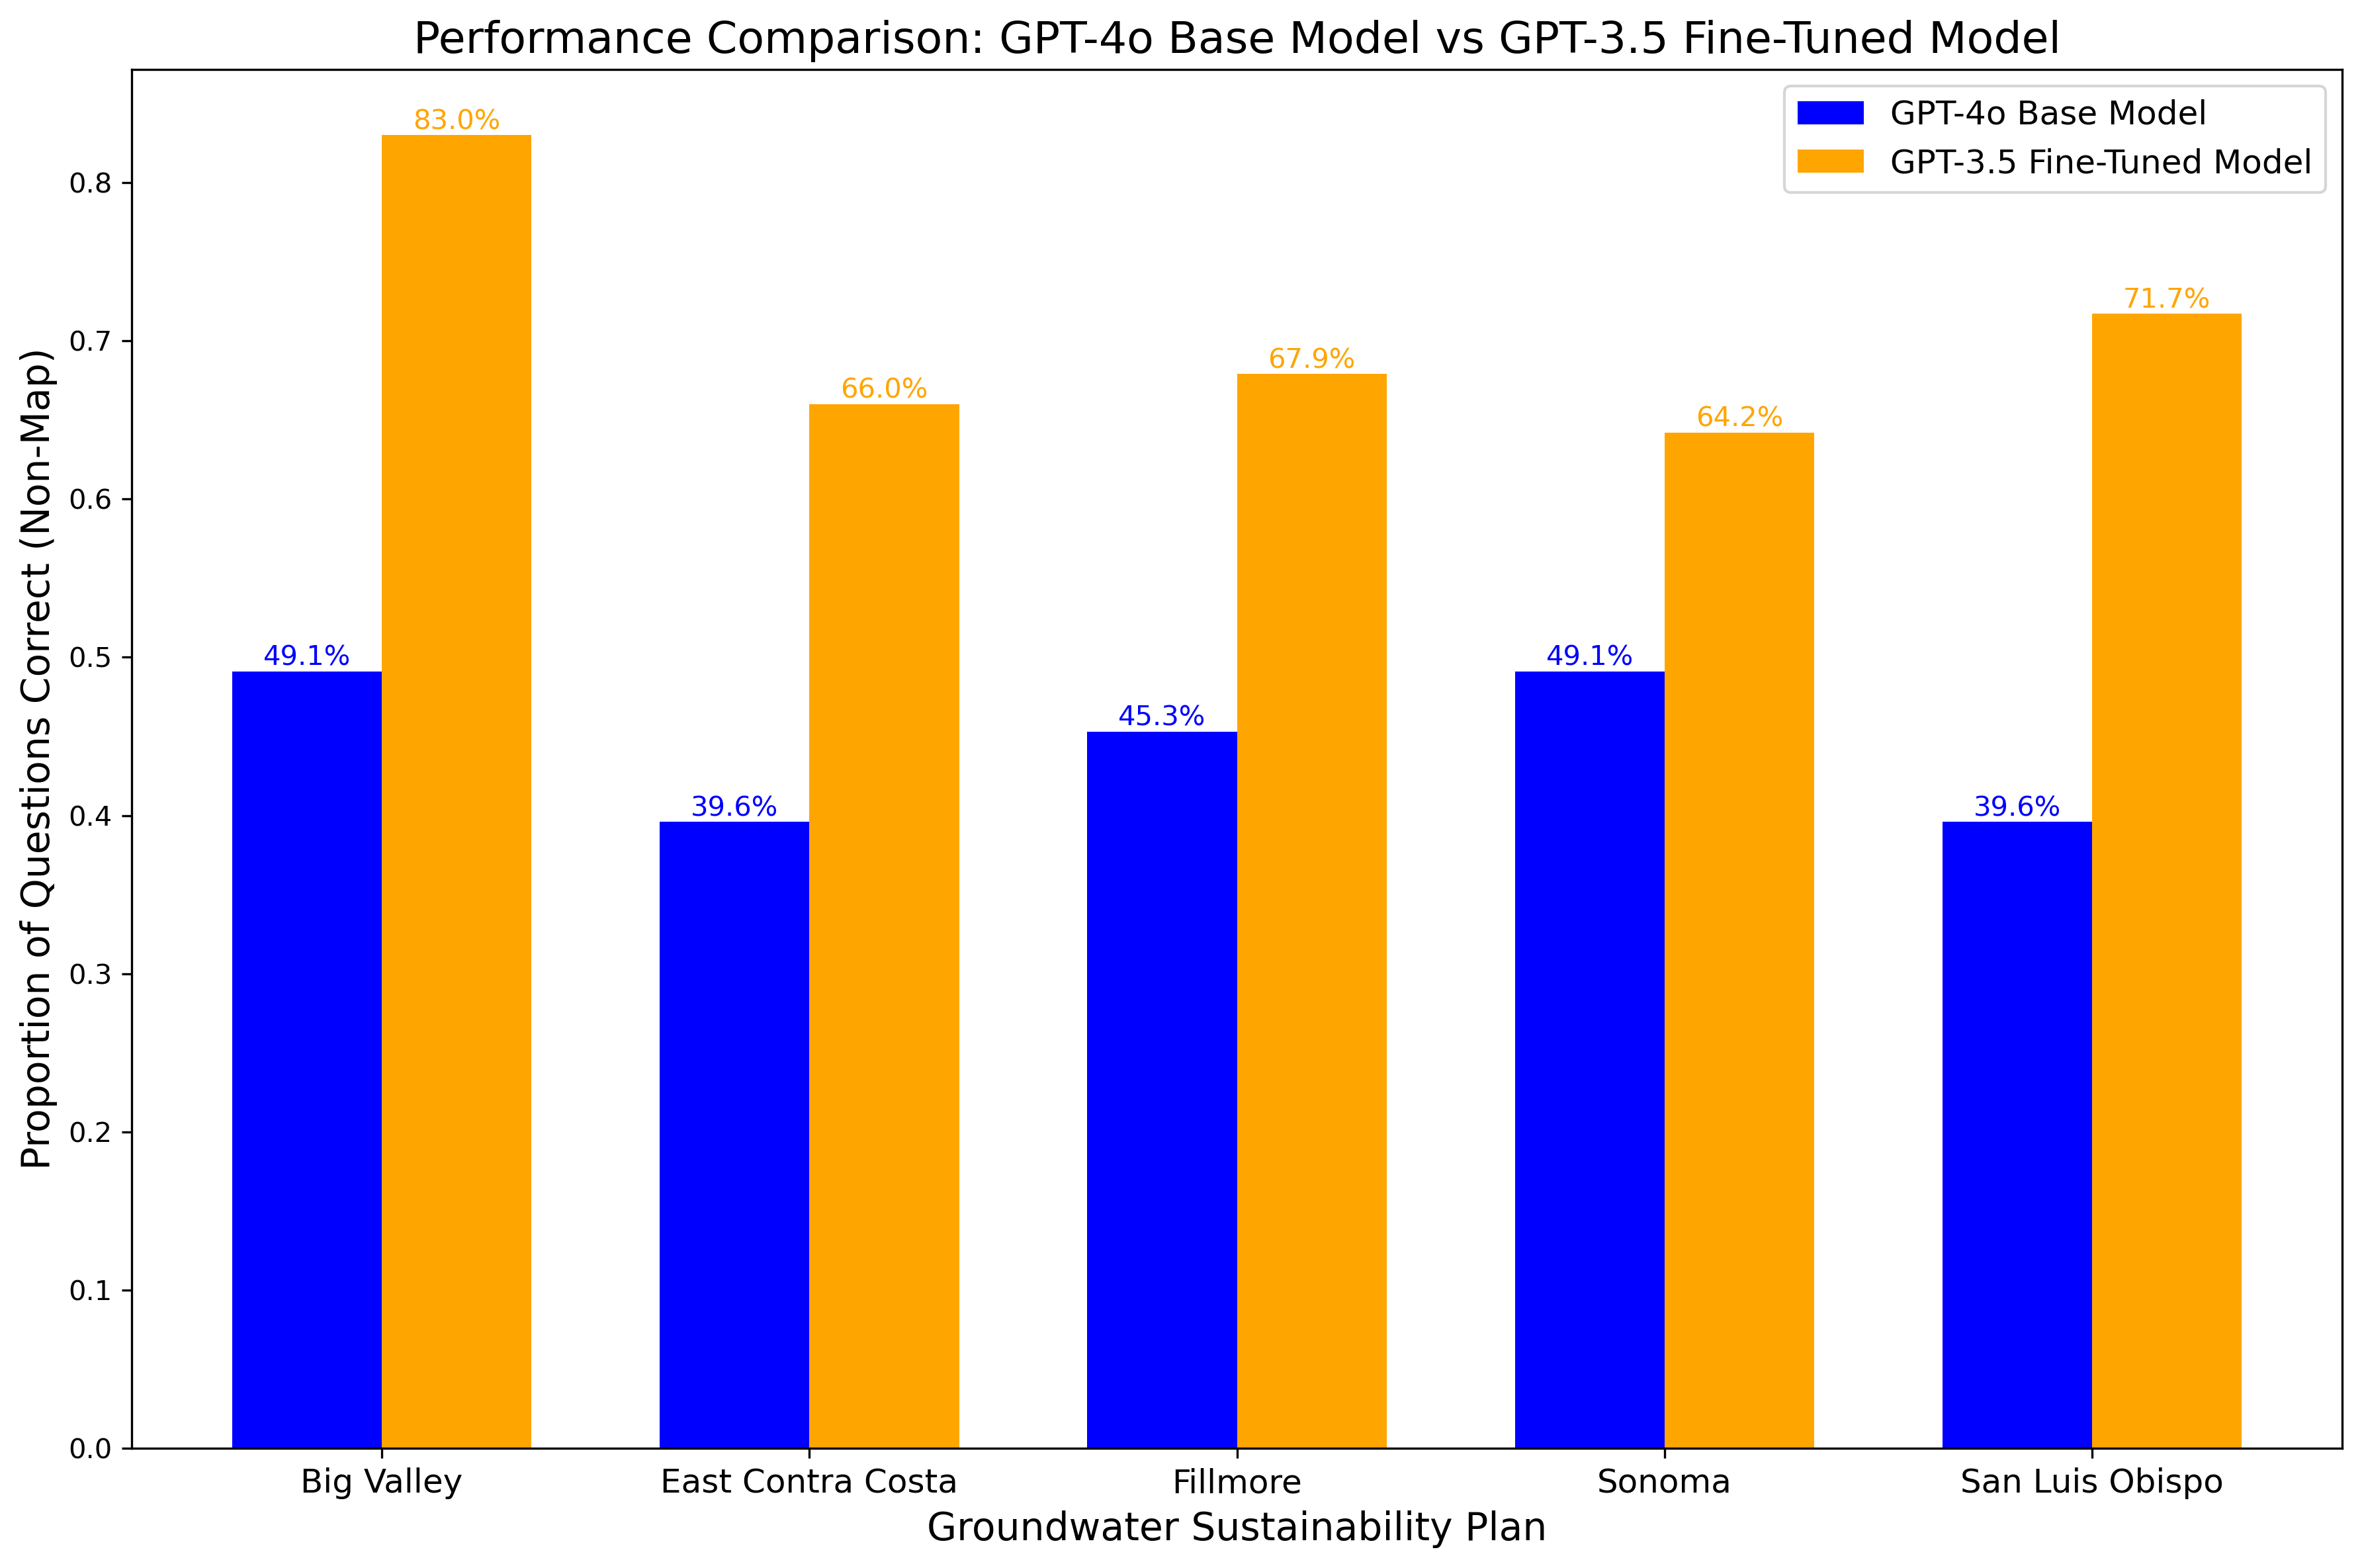

In [214]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the bar chart
x_labels = ['Big Valley', 'East Contra Costa', 'Fillmore', 'Sonoma', 'San Luis Obispo']
model_gpt_4o = [0.491, 0.396, 0.453, 0.491, 0.396]
ft_model_8epoch_LR_0_5 = [0.830, 0.660, 0.679, 0.642, 0.717]
x = np.arange(len(x_labels))  # the label locations

width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8), dpi=300)  # High-resolution figure
bars1 = ax.bar(x - width/2, model_gpt_4o, width, label='GPT-4o Base Model', color='blue')
bars2 = ax.bar(x + width/2, ft_model_8epoch_LR_0_5, width, label='GPT-3.5 Fine-Tuned Model', color='orange')

# Adding titles and labels
ax.set_title('Performance Comparison: GPT-4o Base Model vs GPT-3.5 Fine-Tuned Model', fontsize=16)
ax.set_xlabel('Groundwater Sustainability Plan', fontsize=14)
ax.set_ylabel('Proportion of Questions Correct (Non-Map)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(x_labels, fontsize=12)
ax.legend(fontsize=12)

# Add percentage labels to the bars
for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1%}', va='bottom', ha='center', fontsize=10, color='blue')

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1%}', va='bottom', ha='center', fontsize=10, color='orange')

# Show the plot
plt.tight_layout()
#plt.savefig('performance_comparison.png', bbox_inches='tight')
plt.show()

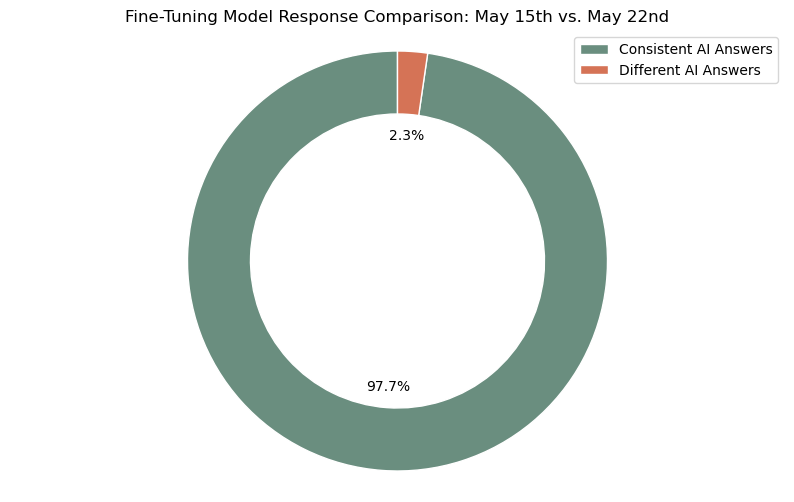

In [137]:
labels = ['Consistent AI Answers', 'Different AI Answers']
sizes = [97.7, 2.3]
colors = ['#6A8E7F', '#D57356']
    
# Create the pie chart
fig, ax = plt.subplots(figsize=(10, 6))
wedges, texts, autotexts = ax.pie(sizes, colors=colors, autopct='%1.1f%%',
                                     startangle=90, wedgeprops=dict(width=0.3, edgecolor='w'))
    
# Add a title
ax.set_title('Fine-Tuning Model Response Comparison: May 15th vs. May 22nd')
    
# Add labels
plt.legend(wedges, labels, loc='best')
    
# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')
    
# Display the plot
plt.show()